In [53]:
import pandas as pd
from cdapython import Q, unique_terms
import plotly.express as px
import plotly.graph_objects as go

In [54]:
def plotlyPie(jsondata):
    #expects {project:{datacategory:count}}
    for project,data  in jsondata.items():
        catlist = []
        countlist = []
        for category, count in data.items():
            catlist.append(category)
            countlist.append(count)
        fig = go.Figure(data=[go.Pie(labels=catlist, values= countlist)])
        fig.update_layout(title_text = project)
        fig.update_traces(textinfo='value')
        fig.show()
        

In [55]:
def projectQuery(querystring):
    query = Q(querystring)
    results = query.run()
    return results

In [56]:
def categoryParse(result):
    finaldata = {}
    for subject in result:
        cathash = {}
        project = subject['associated_project']
        for specimen in subject['Specimen']:
            for file in specimen['File']:
                if file['data_category'] in cathash:
                    cathash[file['data_category']] = cathash[file['data_category']] + 1
                else:
                    cathash[file['data_category']] = 1
        finaldata[project] = cathash
    return finaldata

In [57]:
 def formatQuery(project): 
        querystring = 'ResearchSubject.Specimen.associated_project = ' + '"' + project + '"'
        return querystring

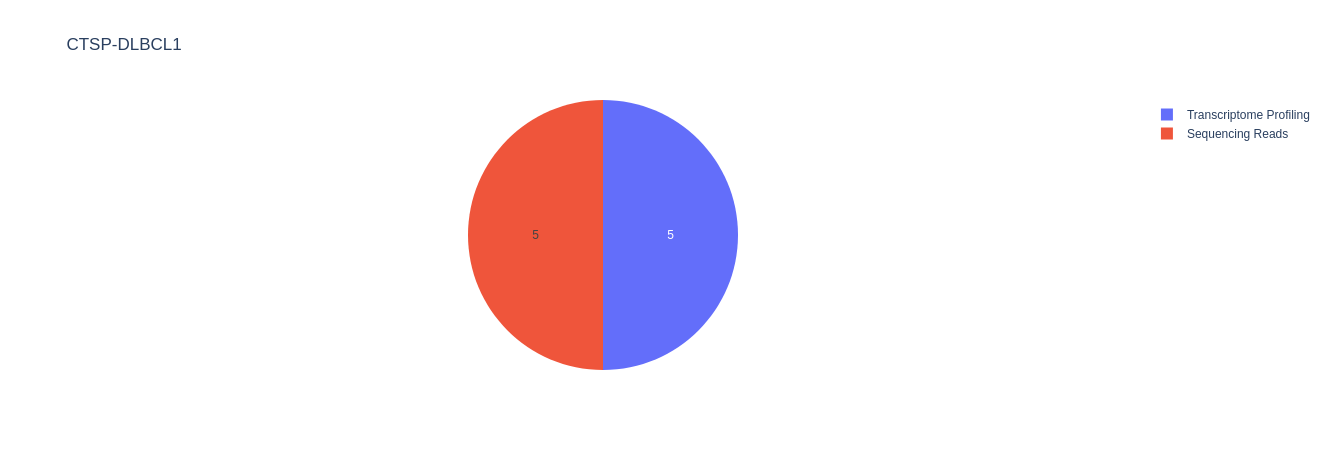

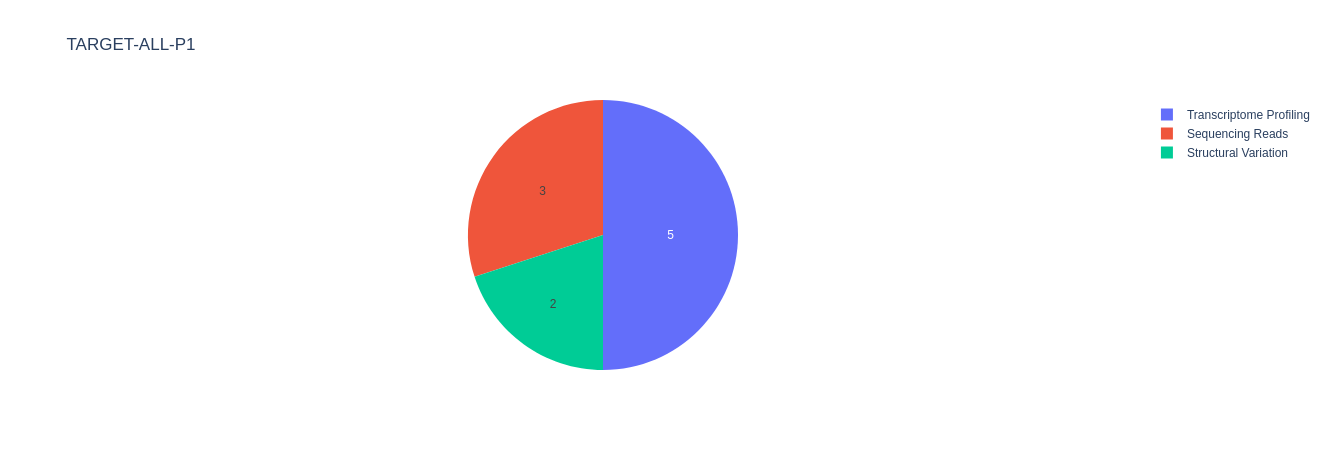

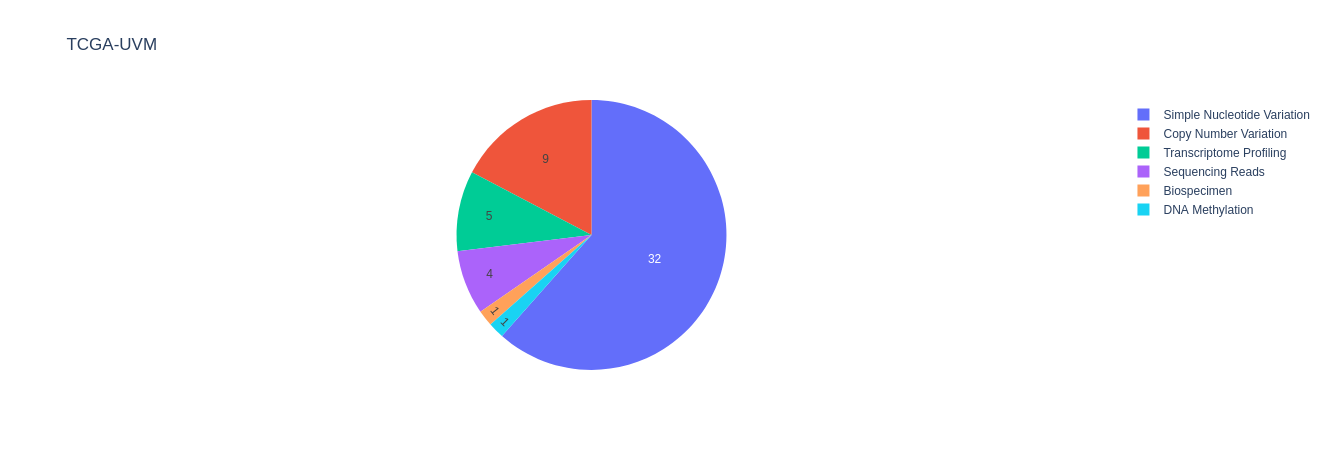

In [58]:
projlist = ['CTSP-DLBCL1','TARGET-ALL-P1', 'TCGA-UVM']
for project in projlist:
    query = formatQuery(project)
    result = projectQuery(query)
    graphdata = categoryParse(result)
    plotlyPie(graphdata)


In [47]:
q1 = Q('ResearchSubject.Specimen.associated_project = "TCGA-UCEC"')

In [40]:
projects = unique_terms('ResearchSubject.Specimen.associated_project')

SELECT DISTINCT(_Specimen.associated_project) FROM `gdc-bq-sample.cda_mvp.v2`, UNNEST(ResearchSubject) AS _ResearchSubject,UNNEST(_ResearchSubject.Specimen) AS _Specimen ORDER BY _Specimen.associated_project


In [41]:
print(projects)

['Academia Sinica LUAD-100', 'BEATAML1.0-COHORT', 'BEATAML1.0-CRENOLANIB', 'CGCI-BLGSP', 'CGCI-HTMCP-CC', 'CMI-ASC', 'CMI-MBC', 'CMI-MPC', 'CPTAC-2', 'CPTAC-3', 'CPTAC-TCGA', 'CPTAC3-Discovery', 'CTSP-DLBCL1', 'FM-AD', 'GENIE-DFCI', 'GENIE-GRCC', 'GENIE-JHU', 'GENIE-MDA', 'GENIE-MSK', 'GENIE-NKI', 'GENIE-UHN', 'GENIE-VICC', 'Georgetown Lung Cancer Proteomics Study', 'HCMI-CMDC', 'Human Early-Onset Gastric Cancer - Korea University', 'Integrated Proteogenomic Characterization of HBV-related Hepatocellular carcinoma', 'MMRF-COMMPASS', 'NCICCR-DLBCL', 'OHSU-CNL', 'ORGANOID-PANCREATIC', 'Oral Squamous Cell Carcinoma - Chang Gung University', 'PJ25730263', 'Proteogenomic Analysis of Pediatric Brain Cancer Tumors Pilot Study', 'TARGET-ALL-P1', 'TARGET-ALL-P2', 'TARGET-ALL-P3', 'TARGET-AML', 'TARGET-CCSK', 'TARGET-NBL', 'TARGET-OS', 'TARGET-RT', 'TARGET-WT', 'TCGA-ACC', 'TCGA-BLCA', 'TCGA-BRCA', 'TCGA-CESC', 'TCGA-CHOL', 'TCGA-COAD', 'TCGA-DLBC', 'TCGA-ESCA', 'TCGA-GBM', 'TCGA-HNSC', 'TCGA-KI